<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours APN - Labo 2 : Comparaison de méthodes <br>de groupement sur des données biomédicales

## Résumé

L'objectif de ce laboratoire est de comparer deux méthodes de groupement : _k_-moyennes et DBSCAN.  

Le jeu de données vient du domaine biomédical et possède une annotation de référence.  

Les tâches demandées sont les suivantes :
* préparer les données à partir de données brutes disponibles en ligne
* pour chaque méthode de groupement
  - décider quels sont les meilleurs hyper-paramètres par évaluation intrinsèque
  - avec ces paramètres, afficher aussi les scores par évaluation extrinsèque
  - visualiser les groupements en 2D
* comparer les deux méthodes de groupement et conclure.

In [114]:
# Nom et prénom : Muhlemann Julien, Ronquillo Cristhian

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["OMP_NUM_THREADS"] = "1" # KMeans is known to have a memory leak ... set OMP_NUM_THREADS=1

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.metrics import davies_bouldin_score as dbs
from sklearn.metrics import silhouette_score as sis
from sklearn.metrics import adjusted_rand_score as ars
from sklearn.metrics import f1_score

from matplotlib.colors import Normalize # peut aider au coloriage des groupes (ou utiliser Seaborn)

## 1. Prise en main et analyse exploratoire des données

Les données biomédicales ont été présentées dans l'article de Todd R. Golub et al., [Molecular classification of cancer: class discovery and class prediction by gene expression monitoring](https://www.science.org/doi/abs/10.1126/science.286.5439.531), *Science*, 286:531-537, 1999.  Ces données représentent l'expression de **7129 gènes** dans des échantillons sanguins et de moëlle osseuse provenant de 72 patients souffrant de leucémie.  Pour chaque gène, son niveau d'expression est codé comme un nombre entier, positif ou négatif.  Le type de leucémie a été annoté pour chaque patient comme ALL ou AML (*acute lymphoblastic leukemia* ou *acute myeloid leukemia*) : ce sont les deux classes de référence.

Les données sont à télécharger depuis [une version fournie par C. Crawford sur Kaggle](https://www.kaggle.com/datasets/crawford/gene-expression) (pour information, une autre version se trouve dans le [package R golubEsets](https://master.bioconductor.org/packages/release/data/experiment/html/golubEsets.html)).  Si vous n'avez pas accès à Kaggle, le fichier `archive.zip` est fourni avec ce notebook.  Les données brutes contiennent :
* un fichier `train` avec les données de 38 patients : noms des gènes (longs et courts), niveau d'expression, signifiance ('call')
* un fichier `independent` avec les données de 34 autres patients
* un fichier `actual` qui indique pour chaque patient son type de leucémie (ALL ou AML)

**Le premier but est d'obtenir une DataFrame avec les 72 patients (lignes) et les niveaux des 7129 gènes (colonnes).  Le numéro de patient sert d'index.  Enfin, une colonne indiquera le type de chaque patient.**

a. Veuillez compléter le code ci-dessous pour transformer le premier fichier de données en un tableau:
* avec 7129 colonnes correspondant à la valeur exprimée de chaque gène pour chaque patient
* les noms des 7129 colonnes sont les noms courts de chaque gène (connus comme *Gene Accession Number*) 
* indexé par le numéro des patients, qui sera appelé 'Patient'

In [116]:
actual = pd.read_csv("archive/actual.csv")
independent = pd.read_csv("archive/data_set_ALL_AML_independent.csv")
train = pd.read_csv("archive/data_set_ALL_AML_train.csv")

In [117]:
genes = train.iloc[:, 2:].select_dtypes(include=["int64"])

In [118]:
genes

,1,2,3,4,5,6,7,8,9,10,...,35,36,37,38,28,29,30,31,32,33
0,-214,-139,-76,-135,-106,-138,-72,-413,5,-88,...,7,-213,-25,-72,-4,15,-318,-32,-124,-135
1,-153,-73,-49,-114,-125,-85,-144,-260,-127,-105,...,-100,-252,-20,-139,-116,-114,-192,-49,-79,-186
2,-58,-1,-307,265,-76,215,238,7,106,42,...,-57,136,124,-1,-125,2,-95,49,-37,-70
3,88,283,309,12,168,71,55,-2,268,219,...,132,318,325,392,241,193,312,230,330,337
4,-295,-264,-376,-419,-230,-272,-399,-541,-210,-178,...,-377,-209,-396,-324,-191,-51,-139,-367,-188,-407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,793,782,1138,627,250,645,1140,1799,758,570,...,752,1293,1733,1567,987,279,737,588,1170,2315
7125,329,295,777,170,314,341,482,446,385,359,...,295,342,304,627,279,51,227,361,284,250
7126,36,11,41,-50,14,26,10,59,115,9,...,28,26,12,21,22,6,-9,-26,39,-12
7127,191,76,228,126,56,193,369,781,244,171,...,1558,246,3193,2520,662,2484,371,133,298,790


In [119]:
def conversion_donnees_brutes(path : str) -> pd.DataFrame:
    # Retourne la DataFrame selon la consigne.
    # Code à compléter :
    # Retourne la DataFrame selon la consigne.
    # Code à compléter :

    # Importer les données
    data = pd.read_csv(path)

    # Extraire les colonnes de gènes
    genes = data.iloc[:, 2:].select_dtypes(include=["int64"])

    # Transposer les données des gènes pour que chaque colonne corresponde à un "Gene Accession Number"
    genes_transposed = genes.T

    # Attribuer les noms des colonnes en utilisant "Gene Accession Number"
    genes_transposed.columns = data["Gene Accession Number"]

    return genes_transposed



In [120]:
train_df = conversion_donnees_brutes(os.path.join('archive', 'data_set_ALL_AML_train.csv'))
print(train_df.shape) # vérifie le résultat : (38, 7129)
train_df.head(3)

(38, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


b. Veuillez appliquer la même fonction au deuxième fichier de données.

In [121]:
test_df = conversion_donnees_brutes(os.path.join('archive', 'data_set_ALL_AML_independent.csv'))
print(test_df.shape) # vérifier le résultat : (34, 7129)
test_df.head(3)

(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
39,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,277,1023,67,214,-135,1074,475,48,168,-70
40,-87,-248,262,295,-226,-493,367,-452,194,162,...,83,529,-295,352,-67,67,263,-33,-33,-21
42,22,-153,17,276,-211,-250,55,-141,0,500,...,413,399,16,558,24,893,297,6,1971,-42


c. Veuillez fusionner les deux data frames en mettant les patients dans l'ordre 1 à 72.

In [122]:
# Veuillez écrire le code ici et appeler le résultat 'total_df'
total_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# trier les colonnes par ordre alphabétique
total_df = total_df.sort_index(axis=1)

total_df

Gene Accession Number,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000381_s_at,AB000409_at,AB000410_s_at,AB000449_at,AB000450_at,AB000460_at,...,Z84721_cds2_at,Z84722_at,Z86000_at,Z93784_at,Z94753_s_at,Z95624_at,Z96810_at,Z97054_xpt2_at,Z97074_at,hum_alu_at
0,151,72,281,36,29,-299,-336,57,186,1647,...,8656,-156,538,434,168,116,-122,398,188,15091
1,263,21,250,43,8,-103,-361,169,219,2043,...,13285,-241,863,506,70,94,-40,649,147,11038
2,88,-27,358,42,11,142,-508,359,237,1997,...,15704,-581,737,770,141,57,-38,701,131,16692
3,484,61,118,39,38,-11,-116,274,245,2128,...,15691,-267,882,348,102,179,-58,533,448,15763
4,118,16,197,39,50,237,-129,311,186,1608,...,3390,-235,386,484,123,66,-45,448,106,18128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,316,0,105,104,75,-76,-383,38,261,1397,...,2621,-202,547,129,-6,121,-11,346,105,22818
68,228,36,106,113,102,19,-95,141,165,1030,...,29136,-178,295,286,86,80,-32,358,65,39323
69,395,73,334,73,115,417,-257,259,359,2656,...,-52,-557,641,230,147,120,30,647,13,15689
70,311,-56,235,46,59,845,-444,168,517,3570,...,252,-1295,1531,2,298,135,-116,948,181,41570


d.  En utilisant le fichier `actual.csv`, veuillez ajouter à **total_df** une colonne intitulée **type**, qui indique pour chaque patient son type de maladie (ALL ou AML).  Attention, cette colonne servira uniquement pour l'évaluation extrinsèque en fin de labo.

In [123]:
# Veuillez écrire le code ici :
total_df['type'] = actual['cancer']

print(total_df.shape)
total_df.head()

(72, 7130)


Gene Accession Number,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000381_s_at,AB000409_at,AB000410_s_at,AB000449_at,AB000450_at,AB000460_at,...,Z84722_at,Z86000_at,Z93784_at,Z94753_s_at,Z95624_at,Z96810_at,Z97054_xpt2_at,Z97074_at,hum_alu_at,type
0,151,72,281,36,29,-299,-336,57,186,1647,...,-156,538,434,168,116,-122,398,188,15091,ALL
1,263,21,250,43,8,-103,-361,169,219,2043,...,-241,863,506,70,94,-40,649,147,11038,ALL
2,88,-27,358,42,11,142,-508,359,237,1997,...,-581,737,770,141,57,-38,701,131,16692,ALL
3,484,61,118,39,38,-11,-116,274,245,2128,...,-267,882,348,102,179,-58,533,448,15763,ALL
4,118,16,197,39,50,237,-129,311,186,1608,...,-235,386,484,123,66,-45,448,106,18128,ALL


e. Y a-t-il des données manquantes dans la Data Frame obtenue ?

In [124]:
# données manquantes
print(total_df.isnull().sum().sum())

0


f. Y a-t-il des *outliers* dans chaque colonne ?  Même s'il y en a, ne pas les supprimer.

g. Veuillez donner un résumé pour chaque colonne numérique (le _5-number-summary_) en utilisant la méthode _describe()_.  Utiliser l'affichage par défaut qui affiche un petit nombre de colonnes.

h. Combien de fois apparaît chaque classe de référence, ALL et AML ?

In [125]:
total_df.iloc[:, :-1]

Gene Accession Number,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000381_s_at,AB000409_at,AB000410_s_at,AB000449_at,AB000450_at,AB000460_at,...,Z84721_cds2_at,Z84722_at,Z86000_at,Z93784_at,Z94753_s_at,Z95624_at,Z96810_at,Z97054_xpt2_at,Z97074_at,hum_alu_at
0,151,72,281,36,29,-299,-336,57,186,1647,...,8656,-156,538,434,168,116,-122,398,188,15091
1,263,21,250,43,8,-103,-361,169,219,2043,...,13285,-241,863,506,70,94,-40,649,147,11038
2,88,-27,358,42,11,142,-508,359,237,1997,...,15704,-581,737,770,141,57,-38,701,131,16692
3,484,61,118,39,38,-11,-116,274,245,2128,...,15691,-267,882,348,102,179,-58,533,448,15763
4,118,16,197,39,50,237,-129,311,186,1608,...,3390,-235,386,484,123,66,-45,448,106,18128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,316,0,105,104,75,-76,-383,38,261,1397,...,2621,-202,547,129,-6,121,-11,346,105,22818
68,228,36,106,113,102,19,-95,141,165,1030,...,29136,-178,295,286,86,80,-32,358,65,39323
69,395,73,334,73,115,417,-257,259,359,2656,...,-52,-557,641,230,147,120,30,647,13,15689
70,311,-56,235,46,59,845,-444,168,517,3570,...,252,-1295,1531,2,298,135,-116,948,181,41570


i. Appliquez la PCA sur des données normalisées (sans la colonne `type`), en **deux** dimensions (sans normaliser le résultat). **Vous travaillerez sur ces données tout au long du labo.**

In [126]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(total_df.iloc[:, :-1])


In [127]:
# Veuillez nommer X_pca le résultat de la PCA sur les colonnes de données.
# Veuillez nommer Y la colonne indiquant le type correct de chaque patient.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(total_df.iloc[:, :-1])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_df)
Y = total_df.iloc[:, -1]


k. À ce stade, après la PCA, les points vous semblent-ils présenter un groupement visible ?

Les points ne semblent pas présenter un groupement visible. Ils sont répartis de manière homogène dans l'espace.
De manière complètement mélangée, sans aucune structure apparente.

C:\Users\Julien\AppData\Local\Temp\ipykernel_11964\3761382133.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("viridis", len(unique_true_labels))


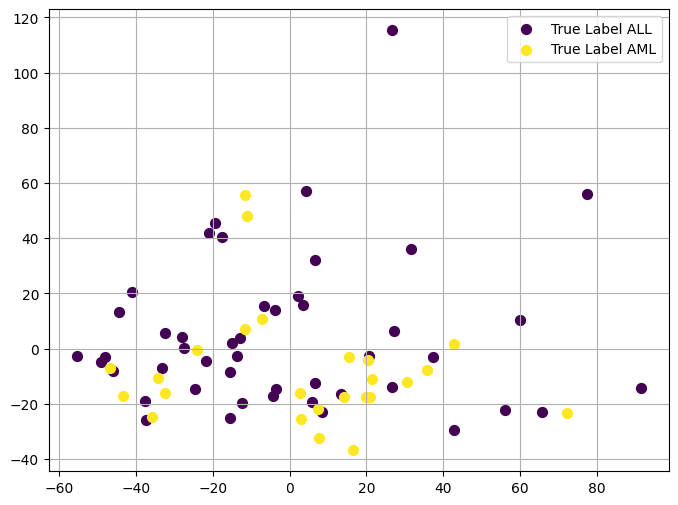

In [128]:
import numpy as np
import matplotlib.pyplot as plt

unique_true_labels = np.unique(Y) 
colors = plt.cm.get_cmap("viridis", len(unique_true_labels))
plt.figure(figsize=(8, 6))

for idx, label in enumerate(unique_true_labels):
    color = colors(idx)
    
    # prendre les points appartenant à la classe label
    class_member_mask = (Y == label)
    plt.scatter(X_pca[class_member_mask, 0], X_pca[class_member_mask, 1], color=color, label=f'True Label {label}', s=50)

plt.legend(loc='best', scatterpoints=1)
plt.grid(True)
plt.show()

## 2. Groupement avec _k_-moyennes

Dans cette section, on vous demande de grouper les patients en utilisant la méthode des _k_-moyennes (avec initialisation _kmeans++_) et de trouver la valeur optimale du nombre de groupes entre 2 et 12, en utilisant l'indice de Davies-Bouldin et le score Silhouette.  Vous *ne* devez *pas* utiliser l'information du type de maladie.

Vu le nombre élevé d'attributs, vous réutiliserez les résultat de l'ACP faite ci-dessus, sans normalisation après l'ACP.

a. Pour les trois scores suivants, veuillez rappeler (en utilisant la documentation de sklearn) quel est leur intervalle de valeurs et quelles valeurs indiquent un meilleur groupement :
* l'indice de Davies-Bouldin
* le coefficient de Silhouette
* l'inertie.

In [129]:
# Veuillez répondre ici.


b. Pour un nombre de groupes _k_ allant de 2 à 12 compris, veuillez effectuer le groupement avec _k_-moyennes, puis représenter sur trois graphiques la variation des trois scores intrinsèques en fonction de _k_.  Utiliser `n_init=10`.

c. Selon les courbes affichées, quelle valeur de _k_ proposez-vous de retenir ?  Veuillez donner une raison.

Si vous exécutez plusieurs fois l'affichage des courbes, la valeur optimale de _k_ reste-t-elle la même ?  Que pouvez-vous en conclure ?

Note : si vous fixez l'attribut `random_seed` de KMeans, alors les courbes ne varient pas au fil des exécutions, sauf si vous changez `n_init`.

In [130]:
# Votre discussion ici.

d. Avec la valeur de _k_ choisie au (c), veuillez calculer deux scores extrinsèques : l'indice de Rand ajusté et le score F1.  Veuillez commenter brièvement ces scores.

_Indication pour calculer le F1-score, qui n'est pas implémenté dans sklearn pour le groupement._  Pour chaque patient, assignez-lui le type qui est majoritaire dans son groupe (ALL ou AML) en utilisant les bonnes réponses.  Puis comparez les types ainsi assignés avec les types corrects en utilisant directement le score F1 de sklearn.  Notez que pour simplifier, cette méthode est un peu différente de celle du cours.

In [131]:
# Effectuer le groupement k-moyennes avec la meilleure valeur de k retenue au (b).


In [132]:
# Calcul et affichage des deux scores.


In [133]:
# Votre commentaire sur les scores.

e. Veuillez représenter les points avec PCA en 2D, en gardant les marqueurs précédents pour les deux types (cercle et triangle), et en utilisant des couleurs pour coder les groupes trouvés. Suggestion : réutiliser le code du Labo 1.  Veuillez commenter le résultat.

In [134]:
# Utiliser le groupement obtenu ci-dessus.


In [135]:
# Veuillez écrire ici votre discussion des résultats, à l'aide du graphique.


## 3. Groupement avec DBSCAN

Dans cette section, vous répondrez aux mêmes questions que dans la section précédente, mais pour la méthode DBSCAN, en utilisant les mêmes mesures intrinsèques que ci-dessus (sauf l'inertie).

a. Veuillez représenter sur des _heatmaps_ la variation des deux scores intrinsèques et le nombre de groupes en fonction des paramètres _eps_ et _min_samples_ :
* chercher _eps_ entre 0.5 et 14 par sauts de 0.5
* chercher _min_samples_ entre 1 et 12

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

all_eps = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.6, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14]
min_sample = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

silhouette_scores = np.zeros((len(all_eps), len(min_sample)))
davies_bouldin_scores = np.zeros((len(all_eps), len(min_sample)))
n_clusters = np.zeros((len(all_eps), len(min_sample)))

for i, ep in enumerate(all_eps):
    for j, m in enumerate(min_sample):
        db = DBSCAN(eps=ep, min_samples=m).fit(X_pca)
        labels = db.labels_

        unique_labels = set(labels)
        n_clusters[i, j] = len(unique_labels)

# si on a au moins 2 clusters
        n_labels = len(unique_labels)
        if 2 <= n_labels <= len(X_pca) - 1:
            silhouette_scores[i, j] = silhouette_score(X_pca, labels)
            davies_bouldin_scores[i, j] = davies_bouldin_score(X_pca, labels)
        else:
            silhouette_scores[i, j] = np.nan
            davies_bouldin_scores[i, j] = np.nan



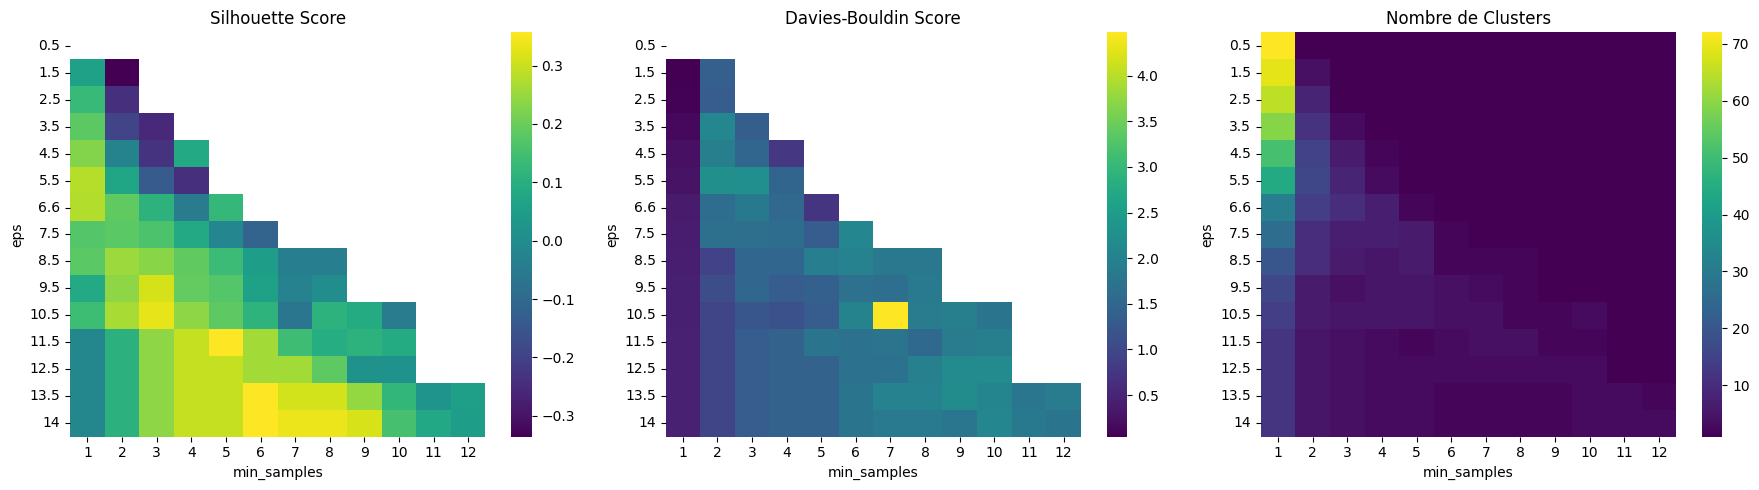

In [144]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(silhouette_scores, xticklabels=min_sample, yticklabels=all_eps, ax=ax[0], cmap='viridis')
ax[0].set_title('Silhouette Score')
ax[0].set_xlabel('min_samples')
ax[0].set_ylabel('eps')

sns.heatmap(davies_bouldin_scores, xticklabels=min_sample, yticklabels=all_eps, ax=ax[1], cmap='viridis')
ax[1].set_title('Davies-Bouldin Score')
ax[1].set_xlabel('min_samples')
ax[1].set_ylabel('eps')

sns.heatmap(n_clusters, xticklabels=min_sample, yticklabels=all_eps, ax=ax[2], cmap='viridis')
ax[2].set_title('Nombre de Clusters')
ax[2].set_xlabel('min_samples')
ax[2].set_ylabel('eps')

plt.tight_layout()
plt.show()

b. Selon les scores trouvés, quelles valeurs de _eps_ et _min_samples_ proposez-vous de retenir ?  Pourquoi ?

Attention : les trois heatmaps ne sont pas toujours en accord, donc vous avez une certaine liberté pour choisir les deux paramètres (il n'y a pas d'optimum évident).

### Votre discussion ici.

#### Score silhouette:
les meilleures zones sont celles où les scores sont proches de 0.6 à 0.8, qui apparaissent pour des valeurs de eps comprises entre environ 11 et 14, avec un min_samples entre 4 et9.

#### Score Davies-Bouldin:
un score plus bas est meilleur. Sur cette heatmap, les valeurs basses (inférieures à 1.5) apparaissent autour de 11 <= eps <= 14 et min_samples < 6.

#### Nombre de clusters:
Il convient d'éviter des nombres de clusters trop élevés ou trop faibles. Par exemple, dans la zone où min_samples =1, le nombre de clusters est très élevé (jusqu'à 50 clusters). En revanche pour un min_sample > 6 le nombre de clusters est très faible (1 à 3 clusters).

Le compromis semble se situer pour des valeurs de eps autour de 11-12 avec min_samples entre 3 et 4, où le nombre de clusters reste raisonnable <= 10.

c. Avec les valeurs choisies au (b), veuillez calculer les deux scores extrinsèques comme dans la partie (2).

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, f1_score
from sklearn.preprocessing import LabelEncoder

eps_optimal = 11
min_samples_optimal = 3

db = DBSCAN(eps=eps_optimal, min_samples=min_samples_optimal).fit(X_pca)
labels_pred = db.labels_

ari_score = adjusted_rand_score(Y, labels_pred)
print(f"ARI indice de Rand: {ari_score}")

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

f1 = f1_score(Y_encoded, labels_pred, average='weighted')
print(f"score F1: {f1}")


ARI indice de Rand: 0.03170347376901569
score F1: 0.5425925925925926


In [139]:
# Votre commentaire sur les scores.
"""
Avec les valeurs trouvées à l'aide des heatmaps (eps =11 et min_samples = 3), nous avons obtenu un score de rand de 0.032 et un score F1 de 54%.
Le score de rand est proche de 0 donc proche d'une classification aléatoire.
"""


"\nAvec les valeurs trouvées à l'aide des heatmaps (eps =11 et min_samples = 3), nous avons obtenu un score de rand de 0.032 et un score F1 de 54%.\nLe score de rand est proche de 0 donc proche d'une classification aléatoire.\n"

d. Veuillez représenter les points en 2D avec la même représentation que ci-dessus : utilisez des marques différentes pour les deux types, et des couleurs pour coder les groupes trouvés.  Veuillez commenter le résultat.

C:\Users\Julien\AppData\Local\Temp\ipykernel_11964\590330760.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("Paired", len(unique_labels))


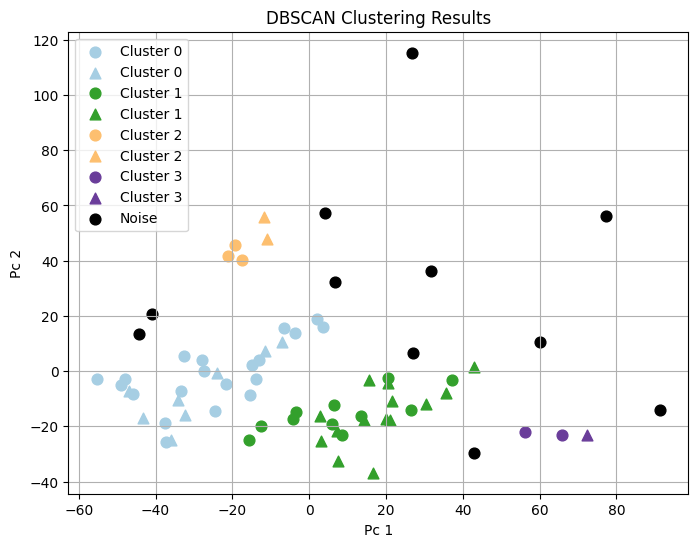

In [150]:

plt.figure(figsize=(8, 6))

unique_labels = set(labels_pred)
colors = plt.cm.get_cmap("Paired", len(unique_labels))

marker_map = {'ALL': 'o', 'AML': '^'}

for k in unique_labels:
    # mettre en noir les points outlier de DBSCAN
    if k == -1:
        color = 'k'
        label = 'Noise'
    else:
        color = colors(k)
        label = f'Cluster {k}'
    # plotter chaque classe
    class_member_mask = (labels_pred == k)
    
    for true_label in np.unique(Y[class_member_mask]):
        true_label_mask = (Y == true_label)
        marker = marker_map[true_label]
        plt.scatter(X_pca[class_member_mask & true_label_mask, 0], 
                    X_pca[class_member_mask & true_label_mask, 1], 
                    color=color, 
                    marker=marker, 
                    label=f'{label}', 
                    s=60)

plt.title('DBSCAN Clustering Results')
plt.xlabel('Pc 1')
plt.ylabel('Pc 2')
plt.legend(loc='best', scatterpoints=1)
plt.grid(True)
plt.show()

In [141]:
# Veuillez commenter le graphique ici.
"""
Ces valeurs indiquent que le groupement DBSCAN n'a pas bien fonctionné sur les données,  les scores sont très bas. 
Les données de base sont très dispersées et les deux classes sont très mélangées, ce qui rend difficile la tâche de groupement.
Nous voyons bien que la densité des données est bien détectée par DBSCAN, mais les groupes ne correspondent pas aux classes réelles AML vs ALL.
"""


"\nCes valeurs indiquent que le groupement DBSCAN n'a pas bien fonctionné sur les données,  les scores sont très bas. \nLes données de base sont très dispersées et les deux classes sont très mélangées, ce qui rend difficile la tâche de groupement.\nNous voyons bien que la densité des données est bien détectée par DBSCAN, mais les groupes ne correspondent pas aux classes réelles AML vs ALL.\n"

## 4. Conclusion

Comment se comparent les deux méthodes optimisées, en termes de scores extrinsèques ?  Veuillez discuter les paramètres trouvés et les scores obtenus.  En particulier, y a-t-il des sous-types des leucémies ALL et AML qui sont visibles sur les groupements que vous obtenus ?  Combien pour chacun ?

In [142]:
# Votre discussion ici.

***
**Fin du Labo 2.**  Veuillez nettoyer ce notebook en gardant seulement les réponses et résultats désirés, l'enregistrer en remplaçant 'student' par votre nom, et le soumettre sur Cyberlearn.